# Decompose Rosenbrock function

### Solve a 5 variable rosenbrock with DE

In [1]:
import sys
CODEBASE = "./codebase"
if CODEBASE not in sys.path:
    sys.path.append(CODEBASE)

from cooperative_evolution_optimizers import GrayBoxOptimizer, RandomGrayBoxOptimizer
from differential_evolution import DifferentialEvolution as DE

from fitness_functions import FunctionFactory
get_rosenbrock = FunctionFactory.get_rosenbrock

import numpy as np
import matplotlib.pyplot as plt
from time import time

def plot_means_errs(xs, nparray):
    means = np.mean(nparray, axis=-1)
    errs = np.std(nparray, axis=-1)
    plt.errorbar(xs, means, yerr=errs, fmt="--o", capsize=5)

## Baseline

In [13]:
func = get_rosenbrock()
N = 30
fitnesses = []
for i in range(N):
    print("{:2} ".format(i), end="")
    de = DE(func, 5, lower_bounds=0, upper_bounds=3, 
                    goal_fitness=pow(10, -10), 
                    population_size=400, max_generations=200)
    while not de.has_converged():
        de.evolve()
    fitnesses.append(de.get_best_fitness(1)[0])

 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

In [14]:
print("Fitnesses found in [{}, {}]".format(np.min(fitnesses), np.max(fitnesses)))
print(np.mean(fitnesses))
print(np.std(fitnesses))

Fitnesses found in [6.716531701636174e-06, 0.020777037848375795]
0.002289464635060175
0.004441723629899898


## Decomposition 1

Write out the rosenbrock function:

$$\sum_{i=0}^{l-2} 100(x_{i+1} - x_i^2)^2 + (1 - x_i)^2 = b(x_0, x_1) + \sum_{i=1}^{l-2}f(x_{i-1}, x_i, x_{i+1}) + e(x_{l-2}, x_{l-1})$$

where

$$\begin{cases}
b(x_0, x_1) = 1 - 2x_0 + x_0^2 + 100x_0^4 - (200-V)x_0^2x_1 \\
f(x_{i-1},x_i,x_{i+1}) = 1 - 2x_i + 101x_i^2 + 100x_i^4 - Vx_{i-1}^2x_i - (200-V)x_i^2x_{i+1} \\
e(x_{l-2}, x_{l-1}) = -Vx_{l-2}^2x_{l-1} + 100x_{l-1}^2
\end{cases}$$

In [2]:
# define the functions:
def bV(V):
    def b(x):
        return 1 - 2*x[0] + x[0]**2 + 100*x[0]**4 - 150*x[1]*x[0]**2
    return b

def fV(V):
    def f(x):
        i = 1
        return 1 - 2*x[i] + 101*x[i]**2 + 100*x[i]**4 - 50*x[i]*x[i-1]**2 - 150*x[i+1]*x[i]**2
    return f

def eV(V):
    def e(x):
        return -50*x[1]*x[0]**2 + 100*x[1]**2
    return e

In [6]:
VTR = pow(10, -4)
# repeat each experiment N times
N = 30
L = 5 # number of variables
pop_size = 400
max_generations = 200
# arguments for the DE
args = {"population_size": pop_size, "max_generations": max_generations}
### Create arrays to store all of the partial results for later plotting

input_spaces = [[0, 1]] + [[i-1, i, i+1] for i in range(1, L-1)] + [[L-2, L-1]]
train_partition = [[i] for i in range(L)]
LB = [0]*L
UB = [3]*L
gas = [DE]*len(train_partition)
ga_arguments = [args]*len(train_partition)

Vs = list(range(-50, 260, 10))
fitnesses = np.zeros((len(Vs), N))
for idx, V in enumerate(Vs):
    print("{} \t".format(V), end=" ")
    
    functions = [bV(V)] + [fV(V)]*(L-2) + [eV(V)]
    
    for exp in range(N):
        print(exp, end=" ")

        gbo = GrayBoxOptimizer(functions = functions,
                          input_spaces = input_spaces,
                          train_partition = train_partition,
                          lower_bounds = LB, upper_bounds = UB,
                          genetic_algorithms = gas,
                          genetic_algorithm_arguments = ga_arguments,
                          max_generations = max_generations,
                          goal_fitness = VTR)
        start = time()
        while not gbo.has_converged():
            gbo.evolve()
        fitnesses[idx, exp] = gbo.get_elite_fitness()

-50 	 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 -40 	 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 -30 	 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 -20 	 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 -10 	 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 0 	 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 10 	 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 20 	 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 	 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 40 	 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 50 	 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 60 	 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 

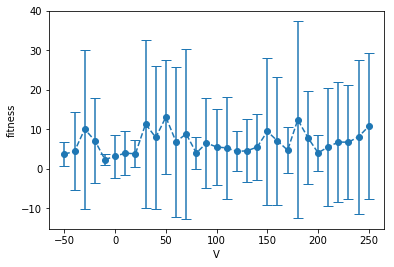

[0.8267265895973174, 0.9194679340755031, 0.7689776694643317, 0.5953729823186675, 0.35446902571284844]
2.3734437661217123


In [7]:
plot_means_errs(Vs, fitnesses)
plt.xlabel("V")
plt.ylabel("fitness")
plt.show()

print(gbo.get_elite_genotype())
print(np.min(np.mean(fitnesses, axis=-1)))

## Decomposition 2

In [48]:
VTR = pow(10, -4)
# repeat each experiment N times
N = 100
L = 5 # number of variables
pop_size = 500
max_generations = 300
# arguments for the DE
args = {"population_size": pop_size, "max_generations": max_generations}
### Create arrays to store all of the partial results for later plotting

def p1(x):
    return 100*(x[1] - x[0]**2)**2

def p2(x):
    return (1 - x[0])**2

functions = [p2]*(L-1) + [p1]*(L-1)
input_spaces = [[i] for i in range(L-1)] + [[i,i+1] for i in range(L-1)]
train_partition = [[i] for i in range(L)]
LB = [0]*L
UB = [3]*L
gas = [DE]*len(train_partition)
ga_arguments = [args]*len(train_partition)

fitnesses_ = np.zeros(N)
for exp in range(N):
    print(exp, end=" ")

    gbo = GrayBoxOptimizer(functions = functions,
                      input_spaces = input_spaces,
                      train_partition = train_partition,
                      lower_bounds = LB, upper_bounds = UB,
                      genetic_algorithms = gas,
                      genetic_algorithm_arguments = ga_arguments,
                      max_generations = max_generations,
                      goal_fitness = VTR)
    start = time()
    while not gbo.has_converged():
        gbo.evolve()
    fitnesses_[exp] = gbo.get_elite_fitness()
    print(gbo.get_elite_genotype())
print(np.mean(fitnesses_))
print(np.std(fitnesses_))

0 [0.8968175098540667, 0.8044923698465021, 0.6485164999829459, 0.4200815151778689, 0.1764684371221503]
1 [0.965179619691191, 0.9314109207452248, 0.867246961808904, 0.7514078730755088, 0.5646137917198599]
2 [0.7064603526679736, 0.08871938539852704, 0.014877954343549049, 0.4092047385966711, 0.16744851808996994]
3 [0.9534114574165639, 0.8895144059139214, 0.7843679069012346, 0.613060019308576, 0.3758425872746237]
4 [0.5982676254570809, 0.3607918669237663, 0.13878406765094303, 0.02883309319132361, 0.0008313472573633067]
5 [0.8009541247458702, 0.2909078562215902, 0.09379159040356072, 0.018610754942149758, 0.000346360195867583]
6 [0.9287266202187276, 0.8623353575221268, 0.7429977677682463, 0.5509908975444553, 0.3035909691768444]
7 [0.9092676193708276, 0.7977253576813361, 0.6367964447526249, 0.40306990998471853, 0.16246323506145485]
8 [0.4108345470048168, 0.21953317144240042, 0.14584150609389498, 0.07876871518693074, 0.204110748070524]
9 [0.9646092198112923, 0.9302875007388576, 0.8651497116437

78 [0.8479157132056262, 0.7191104633648063, 0.5197830862617293, 0.2707862806030758, 0.0733252097628477]
79 [0.841834367163516, 0.3963879857653353, 0.6674067800655392, 0.565826957261106, 0.3201601455633615]
80 [0.9660070148228609, 0.9330933111136765, 0.8703480264148734, 0.7566456871344874, 0.5724836446547334]
81 [0.45983977363386347, 0.21642961166127223, 0.05729538263501327, 0.013085082326098578, 0.00017121937948076285]
82 [0.8843330929384983, 0.7818134579203134, 0.609688882403389, 0.37157998931584674, 0.13807161635607912]
83 [0.8366429296297099, 0.6994838120061325, 0.4899594639737476, 0.24175491817479772, 0.05844544046170314]
84 [0.7799097782775986, 0.609818080579436, 0.3707622353568704, 0.14343120734790732, 0.02057251081218681]
85 [0.9998476284641228, 0.8676276504314988, 0.6935960127696784, 0.46076607689724364, 0.18918992383474975]
86 [0.9278291243589117, 0.8606250747244681, 0.7401368069920987, 0.5460928400989704, 0.29821739000735964]
87 [0.9813919388273186, 0.9361032375508075, 0.8534

## Weighted decomposition 2 (1/100 & 99/100)

In [19]:
VTR = pow(10, -10)
# repeat each experiment N times
N = 100
L = 5 # number of variables
pop_size = 400
max_generations = 200
# arguments for the DE
args = {"population_size": pop_size, "max_generations": max_generations}
### Create arrays to store all of the partial results for later plotting

W1 = 1/100
W2 = 1 - W1
def wp1(x):
    return W1*(100*(x[1] - x[0]**2)**2)

def wp2(x):
    return W2*((1 - x[0])**2)

functions = [wp2]*(L-1) + [wp1]*(L-1)
input_spaces = [[i] for i in range(L-1)] + [[i,i+1] for i in range(L-1)]
train_partition = [[i] for i in range(L)]
LB = [0]*L
UB = [3]*L
gas = [DE]*len(train_partition)
ga_arguments = [args]*len(train_partition)

fitnesses_ = np.zeros(N)
real_fitnesses_ = np.zeros(N)
ros = get_rosenbrock()
for exp in range(N):
    print(exp, end=" ")

    gbo = GrayBoxOptimizer(functions = functions,
                      input_spaces = input_spaces,
                      train_partition = train_partition,
                      lower_bounds = LB, upper_bounds = UB,
                      genetic_algorithms = gas,
                      genetic_algorithm_arguments = ga_arguments,
                      max_generations = max_generations,
                      goal_fitness = VTR)
    start = time()
    while not gbo.has_converged():
        gbo.evolve()
    fitnesses_[exp] = gbo.get_elite_fitness()
    eg = gbo.get_elite_genotype()
    real_fitnesses_[exp] = ros(eg)
    print(eg)
print(np.mean(real_fitnesses_))
print(np.std(real_fitnesses_))
print(sum(real_fitnesses_ < VTR))

0 [0.9904462428468289, 0.9780953355811157, 0.9456251988861676, 0.8656837058061001, 0.727221503132846]
1 [0.9964832687264219, 0.9913255858607367, 0.979262531117858, 0.9486521996073711, 0.8999409958199035]
2 [0.985691196455818, 0.9668738168421563, 0.9196658259417518, 0.8054279221266967, 0.6487141377413281]
3 [0.9931703449218021, 0.9840315452903358, 0.959088419288626, 0.895017985861722, 0.8010571950159736]
4 [0.9874632694465042, 0.970957099272614, 0.9290773781328799, 0.8294837941613153, 0.6877561584903354]
5 [0.9851012727509539, 0.9653243370979719, 0.9131010962313632, 0.7763777670831512, 0.5983565558361453]
6 [0.9926885523921004, 0.9828331019974099, 0.9579474816513972, 0.892003648106106, 0.7956705082346017]
7 [0.9958483364326213, 0.990522512646905, 0.9765990136724126, 0.9414199889663577, 0.886271595625417]
8 [0.992657629687453, 0.9826225880870507, 0.9557574975623606, 0.9010747766703162, 0.8119357531514603]
9 [0.9906944516341205, 0.9783236036727148, 0.947172212632184, 0.8730457000263618, 0

80 [0.9908728766178906, 0.979134925344817, 0.9477574969775444, 0.8822862647694695, 0.7784290530008624]
81 [0.9946327422876658, 0.9871524093589465, 0.9669590581768797, 0.928178268503643, 0.8615148981224209]
82 [0.9991187767225209, 0.9979791688423891, 0.9948680826655361, 0.987452133308155, 0.9750617155748262]
83 [0.9897853078676729, 0.9760856067401807, 0.9429354761304758, 0.8599923191778476, 0.7395337195245829]
84 [0.994919644691344, 0.9880491766688435, 0.9708580888853823, 0.9285449921896394, 0.8620886568207616]
85 [0.995818756842591, 0.9904428456810694, 0.9767875116490218, 0.9413167056418569, 0.8857777254441201]
86 [0.9954805020074671, 0.9889947257948554, 0.9731277505524597, 0.9348407206592386, 0.8737952041804873]
87 [0.9897221406117739, 0.9748560736948731, 0.9419627324100939, 0.8598140991375979, 0.7383086373797185]
88 [0.9808230562430634, 0.9551462028558915, 0.8865693441673745, 0.7112252506718535, 0.4302780215305024]
89 [0.9985956185110544, 0.9966721756621699, 0.9914412658780478, 0.977

## Weighted decomposition 2 (1/1000, 999/1000)

In [2]:
VTR = pow(10, -10)
# repeat each experiment N times
N = 100
L = 5 # number of variables
pop_size = 400
max_generations = 200
# arguments for the DE
args = {"population_size": pop_size, "max_generations": max_generations}
### Create arrays to store all of the partial results for later plotting

W1 = 1/1000
W2 = 1 - W1
def wp1(x):
    return W1*(100*(x[1] - x[0]**2)**2)

def wp2(x):
    return W2*((1 - x[0])**2)

functions = [wp2]*(L-1) + [wp1]*(L-1)
input_spaces = [[i] for i in range(L-1)] + [[i,i+1] for i in range(L-1)]
train_partition = [[i] for i in range(L)]
LB = [0]*L
UB = [3]*L
gas = [DE]*len(train_partition)
ga_arguments = [args]*len(train_partition)

fitnesses_ = np.zeros(N)
real_fitnesses_ = np.zeros(N)
ros = get_rosenbrock()
for exp in range(N):
    print(exp, end=" ")

    gbo = GrayBoxOptimizer(functions = functions,
                      input_spaces = input_spaces,
                      train_partition = train_partition,
                      lower_bounds = LB, upper_bounds = UB,
                      genetic_algorithms = gas,
                      genetic_algorithm_arguments = ga_arguments,
                      max_generations = max_generations,
                      goal_fitness = VTR)
    start = time()
    while not gbo.has_converged():
        gbo.evolve()
    fitnesses_[exp] = gbo.get_elite_fitness()
    eg = gbo.get_elite_genotype()
    real_fitnesses_[exp] = ros(eg)
    print(eg)
print(np.mean(real_fitnesses_))
print(np.std(real_fitnesses_))
print(sum(real_fitnesses_ < 0.00229))

0 [0.9999999092519601, 0.9999998184625821, 0.9999986847434356, 0.9999908805868978, 0.9999816463504397]
1 [0.9999506887009527, 0.9996908088953321, 0.9979606551460566, 0.9850585516560574, 0.9703364387461316]
2 [0.9999997447244414, 0.9999982143466386, 0.9999868718066741, 0.9999382442914724, 0.9998764923967123]
3 [0.9999997781038905, 0.9999984478367578, 0.9999901836711661, 0.9999318170366448, 0.9998636373765393]
4 [0.9999999861427954, 0.99999987711126, 0.9999991346993671, 0.9999926295215976, 0.9999852244130701]
5 [0.9999998179315952, 0.9999988500512119, 0.9999915632146736, 0.9999410303139167, 0.9998820640775794]
6 [0.9999989692047022, 0.9999927895308856, 0.9999495320355101, 0.9996449235951042, 0.9992899705974291]
7 [0.9999983223615173, 0.9999882649013904, 0.9999137224661705, 0.9993650524541013, 0.9987305080642521]
8 [0.999982047031692, 0.9998744174803058, 0.9990766431700491, 0.9961797960761679, 0.9923741861103554]
9 [0.9999996346754048, 0.9999995048680675, 0.9999996309407391, 0.99999242663

80 [0.999978974472072, 0.9998529243106574, 0.9989185988457158, 0.9949741694405988, 0.9899735962680885]
81 [0.9999952233061643, 0.9999665869722915, 0.9997758078275674, 0.9983528736216, 0.996708460104202]
82 [0.9999999597751797, 0.9999997548737237, 0.9999982528482538, 0.99999645401917, 0.9999739562948932]
83 [0.9999999545614519, 0.9999996821573595, 0.9999979179792775, 0.9999847130604511, 0.9999694263545927]
84 [0.9999999641510277, 0.9999997489811, 0.9999982282540393, 0.9999964044259231, 0.9999752495114912]
85 [0.9999997803507495, 0.9999997894761239, 0.9999974743700357, 0.9999939274288111, 0.9999651626132744]
86 [0.9999997876684058, 0.9999998865177949, 0.9999987803803327, 0.9999913149050532, 0.9999825581628048]
87 [0.999998869780339, 0.9999920941147185, 0.999941016235113, 0.9995658073325323, 0.9991318031869875]
88 [0.9999403530629066, 0.999582754541473, 0.9969316262638205, 0.977378501356839, 0.9552687348889969]
89 [0.9999996926056444, 0.9997750055119086, 0.9983137457955488, 0.987574066154

## Random decomposition 2

In [8]:
VTR = 0.00229
# repeat each experiment N times
N = 100
L = 5 # number of variables
pop_size = 400
max_generations = 200
# arguments for the DE
args = {"population_size": pop_size, "max_generations": max_generations}
### Create arrays to store all of the partial results for later plotting

def p1(x):
    return 100*(x[1] - x[0]**2)**2

def p2(x):
    return (1 - x[0])**2

functions = [p2]*(L-1) + [p1]*(L-1)
input_spaces = [[i] for i in range(L-1)] + [[i,i+1] for i in range(L-1)]
train_partition = [[i] for i in range(L)]
LB = [0]*L
UB = [3]*L
gas = [DE]*len(train_partition)
ga_arguments = [args]*len(train_partition)

fitnesses_ = np.zeros(N)
for exp in range(N):
    print(exp, end=" ")

    gbo = RandomGrayBoxOptimizer(functions = functions,
                      input_spaces = input_spaces,
                      train_partition = train_partition,
                      lower_bounds = LB, upper_bounds = UB,
                      genetic_algorithms = gas,
                      genetic_algorithm_arguments = ga_arguments,
                      max_generations = max_generations,
                      goal_fitness = VTR)
    start = time()
    while not gbo.has_converged():
        gbo.evolve()
    fitnesses_[exp] = gbo.get_elite_fitness()
    print(gbo.get_elite_genotype())
print(np.mean(fitnesses_))
print(np.std(fitnesses_))
print(sum(fitnesses_ <= VTR))

0 [0.9197307246058972, 0.845873525462602, 0.7171382085402009, 0.52132252069925, 0.27177717058821993]
1 [0.9713633524693389, 0.9435064849510599, 0.8899862024263288, 0.7913918160429099, 0.6262568304009603]
2 [0.8319688138292051, 0.6294919494774479, 0.4050936317171703, 0.17237707973623068, 0.029713857571332526]
3 [0.8966799158010135, 0.8034595086303176, 0.6457281183059023, 0.4161738711978279, 0.16671140445087002]
4 [0.8024623163411587, 0.5589772717296426, 0.3273566534075167, 0.11964819411073638, 0.014315690353960452]
5 [0.9229450748464468, 0.8515197354697156, 0.7242517090064111, 0.5221792089057113, 0.27248735168596777]
6 [0.9649819241678657, 0.9310776484320993, 0.8666389313437649, 0.7503343663134476, 0.5629662288076199]
7 [0.9125631871357999, 0.5557510934391778, 0.33977715830619454, 0.15123028088335078, 0.022870597856057173]
8 [0.550351261005505, 0.30400349535962873, 0.10095199182707358, 0.01998969387853584, 0.0003995878088277688]
9 [0.9177680897583468, 0.8004533451558241, 0.6234449421913

78 [0.9346811948334898, 0.8734688119387543, 0.762423255429704, 0.57998903664874, 0.33485377006032135]
79 [0.9538178265008468, 0.880696255313764, 0.7809425091063491, 0.7533523939301631, 0.5675398294403076]
80 [0.8736482581476595, 0.13315025065401742, 0.03522101929684651, 0.9653304397497434, 0.9318628579074331]
81 [0.8327991224236639, 0.359003592556233, 0.14014709538128076, 0.029430823049866266, 0.0008661733453925395]
82 [0.9915807591119623, 0.9832108110210517, 0.9666211636985227, 0.9341919760942979, 0.8724578903970073]
83 [0.9518546487496571, 0.9055721178391772, 0.8298045211209844, 0.6934210854673202, 0.48083280177067655]
84 [0.8357524607657758, 0.6994381738400524, 0.49118813643039216, 0.24381161528289294, 0.05944410374685344]
85 [0.47256189074925814, 0.2313764962104172, 0.06413187437618609, 0.013815207702838242, 0.0001908599638725611]
86 [0.899492180717092, 0.8085969429657923, 0.6524142333529304, 0.42440938402738887, 0.1801011406212475]
87 [0.8409980623658004, 0.7070870117794315, 0.498